In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCPCN, Classifier
from pclib.optim.eval import track_vfe
from pclib.utils.functional import format_y, identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset
from tqdm import tqdm
from pclib.optim.train import val_pass
import math
from pclib.optim.train_iPC import train_iPC, train_iPC_classifier

from torchviz import make_dot

In [3]:
seed = 42
# For reproducibility
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
torch.manual_seed(seed)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)

INPUT_SHAPE = 784
NUM_CLASSES = 10

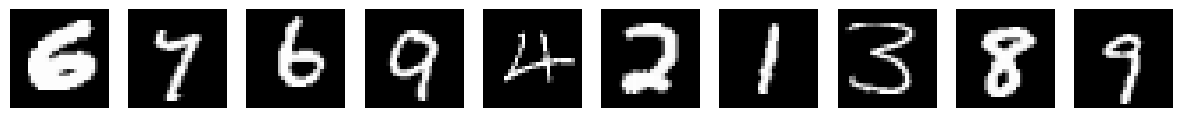

Max value:  tensor(2.8215, device='cuda:0')
Min value:  tensor(-0.4242, device='cuda:0')


In [5]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [6]:
all_stats = {}

In [7]:
# Calculate Correlation between activations of top latent vector
def calc_corr(state):
    # Standardise activations
    mean = state['z'].mean(dim=0, keepdim=True)
    std = state['z'].std(dim=0, keepdim=True) + 1e-5
    z = (state['z'] - mean) / std

    # Compute Correlation matrix
    corr_matrix = torch.corrcoef(z.T)
    mask = torch.triu(torch.ones_like(corr_matrix), diagonal=1).bool()
    correlation = torch.nanmean(corr_matrix.masked_select(mask).abs())
    
    return correlation
def train(
        model,
        train_dataset,
        val_dataset,
        BATCH_SIZE,
        NUM_EPOCHS,
        optimiser,
        scheduler,
        stats,
        cd=None,
        eval_every=1,
):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    pos_states = [model.init_state(images.flatten(1)) for images, _ in train_loader]

    model.train()

    loop = tqdm(range(NUM_EPOCHS), leave=False)
    for i in loop:

        if stats['epoch'] > 0:
            postfix = {'steps': i, 'posVFE': stats['posVfe'][-1], 'corr': stats['corr'][-1], 'valVFE': stats['valVfe'][-1]}
            if cd:
                postfix['cdVFE'] = stats['cdVfe'][-1]
            loop.set_postfix(postfix)
        
        epoch_stats = {'posVfe': [], 'negVfe': [], 'cdVfe': [], 'negMse': [], 'corr': []}
        
        model.train()
        for state in pos_states:

            # Update particles and calculate new VFE
            model.step(state)
            optimiser.zero_grad()
            pos_vfe = model.vfe(state) / BATCH_SIZE
            pos_vfe.backward()
            pos_vfe = pos_vfe.item()
            

            # if cd:
            #     cd_state = {k: v.clone() for k, v in state.items()}
                
            #     cd_state = model.reconstruct(cd_state[0]['x'], steps=cd)

            #     cd_vfe = model.vfe(cd_state)
            #     loss += -0.75 * cd_vfe

            # .backward()
            optimiser.step()
            

            epoch_stats['posVfe'].append(pos_vfe)
            epoch_stats['corr'].append(calc_corr(state).item())
            # if cd:
            #     epoch_stats['cdVfe'].append(cd_vfe.item())

        pos_vfe = sum(epoch_stats['posVfe']) / len(epoch_stats['posVfe'])
        stats['posVfe'].append(sum(epoch_stats['posVfe']) / len(epoch_stats['posVfe']))
        stats['corr'].append(sum(epoch_stats['corr']) / len(epoch_stats['corr']))
        # if cd:
        #     stats['cdVfe'].append(sum(epoch_stats['cdVfe']) / len(epoch_stats['cdVfe']))

        # Update learning rate
        # if scheduler is not None:
        #     scheduler.step(stats['posVfe'][-1])
        if i % eval_every == 0:
            # train_dataset.apply_transform()
            model.eval()
            state = model(val_dataset.transformed_images.flatten(1))
            val_vfe = model.vfe(state) / len(val_dataset)
            stats['valVfe'].append(val_vfe.item())
            # if len(stats['valVfe']) > 1:
            #     if stats['valVfe'][-1] > stats['valVfe'][-2]:
            #         break

        
        stats['epoch'] += 1
    
# def train(
#         model,
#         train_dataset,
#         val_dataset,
#         BATCH_SIZE,
#         NUM_EPOCHS,
#         optimiser,
#         scheduler,
#         stats,
#         cd=None,
#         eval_every=1,
# ):
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#     model.train()

#     # loop = tqdm(range(NUM_EPOCHS), leave=False)
#     # for i in loop:
#     for i in range(NUM_EPOCHS):
#         train_dataset.apply_transform()

#         # if stats['epoch'] > 0:
#         #     postfix = {'steps': i, 'posVFE': stats['posVfe'][-1], 'corr': stats['corr'][-1], 'valVFE': stats['valVfe'][-1]}
#         #     if cd:
#         #         postfix['cdVFE'] = stats['cdVfe'][-1]
#         #     loop.set_postfix(postfix)
        
#         epoch_stats = {'posVfe': [], 'negVfe': [], 'cdVfe': [], 'negMse': [], 'corr': []}
        
#         model.train()
#         loop = tqdm(train_loader, leave=False)
#         loop.set_description(f'Epoch [{i}/{NUM_EPOCHS}]')
#         if stats['epoch'] > 0:
#             loop.set_postfix({'posVfe': stats['posVfe'][-1], 'corr': stats['corr'][-1], 'valVfe': stats['valVfe'][-1]})
#         for images, _ in loop:

#             # Update particles and calculate new VFE
#             state = model(images.flatten(1))
#             optimiser.zero_grad()
#             pos_vfe = model.vfe(state) / BATCH_SIZE
#             pos_vfe.backward()
#             pos_vfe = pos_vfe.item()
            

#             # if cd:
#             #     cd_state = {k: v.clone() for k, v in state.items()}
                
#             #     cd_state = model.reconstruct(cd_state[0]['x'], steps=cd)

#             #     cd_vfe = model.vfe(cd_state)
#             #     loss += -0.75 * cd_vfe

#             # .backward()
#             optimiser.step()
            

#             epoch_stats['posVfe'].append(pos_vfe)
#             epoch_stats['corr'].append(calc_corr(state).item())
#             # if cd:
#             #     epoch_stats['cdVfe'].append(cd_vfe.item())

#         pos_vfe = sum(epoch_stats['posVfe']) / len(epoch_stats['posVfe'])
#         stats['posVfe'].append(sum(epoch_stats['posVfe']) / len(epoch_stats['posVfe']))
#         stats['corr'].append(sum(epoch_stats['corr']) / len(epoch_stats['corr']))
#         # if cd:
#         #     stats['cdVfe'].append(sum(epoch_stats['cdVfe']) / len(epoch_stats['cdVfe']))

#         # Update learning rate
#         if i % eval_every == 0:
#             model.eval()
#             state = model(val_dataset.transformed_images.flatten(1))
#             val_vfe = model.vfe(state) / len(val_dataset)
#             stats['valVfe'].append(val_vfe.item())
#             # if len(stats['valVfe']) > 1:
#             #     if stats['valVfe'][-1] > stats['valVfe'][-2]:
#             #         break
#             if scheduler is not None:
#                 scheduler.step(stats['valVfe'][-1])

        
#         stats['epoch'] += 1
    

In [8]:
torch.manual_seed(42)
class Model(nn.Module):
    def __init__(self, gamma=0.1, steps=30, bias=True):
        super().__init__()
        self.gamma = gamma
        self.steps = steps
        # self.layers = nn.Sequential(*[
        #     nn.ELU(),
        #     nn.Linear(64, 256, bias=bias),
        #     nn.ELU(),
        #     # nn.BatchNorm1d(128),
        #     nn.Linear(256, 256, bias=bias),
        #     nn.ELU(),
        #     # nn.BatchNorm1d(256),
        #     nn.Linear(256, 784, bias=bias),
        #     # nn.ReLU(),
        # ])
        self.layers = nn.Sequential(*[
            nn.Unflatten(1, (64, 1, 1)),
            # nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=1, padding=0, output_padding=0, bias=bias),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1, output_padding=0, bias=bias),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1, output_padding=0, bias=bias),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, 3, stride=2, padding=3, output_padding=1, bias=bias),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, 5, stride=1, padding=2, bias=bias),
            # nn.Conv2d(16, 1, 5, stride=1, padding=0, bias=bias),
            nn.Flatten(1),
        ])

        self.device = torch.device('cpu')

    
    def to(self, device):
        self.device = device
        return super().to(device)

    def init_state(self, obs):
        # state = {'obs': obs, 'z': torch.zeros((obs.shape[0], 64)).to(obs.device)}
        state = {'obs': obs, 'z': torch.randn((obs.shape[0], 64)).to(obs.device) * 0.1}
        state['z'].requires_grad = True
        state['optimiser'] = torch.optim.AdamW([state['z']], lr=self.gamma, weight_decay=0.02)
        return state
    
    def predict(self, z):
        # return F.linear(F.elu(z), self.weight, self.bias)
        # for layer in self.layers:
        #     # z = F.elu(layer(z))
        #     z = layer(F.elu(z))
        # return z
        return self.layers(z)
    
    def vfe(self, state, batch_reduction=True):
        pred = self.predict(state['z'])
        vfe = (0.5 * (state['obs'] - pred).square()).sum(1)
        if batch_reduction:
            vfe = vfe.sum(0)
        return vfe

    def step(self, state, gamma=None):
        if gamma is None:
            gamma = torch.ones(state['z'].shape[0]).to(state['z'].device) * self.gamma
        # state['z'] = state['z'].clone().requires_grad_()
        # state['z'] = state['z'].detach().requires_grad_()
        state['optimiser'].zero_grad()
        # state['optim'].param_groups[0]['params'] = [state['z']]
        vfe = self.vfe(state)
        vfe.backward()
        state['optimiser'].step()
        # state['z'].data = state['z'].data - gamma.unsqueeze(1) * state['z'].grad

    def update_gamma(self, state, gamma, prev_vfe=None):
        vfe = self.vfe(state, batch_reduction=False)
        if prev_vfe is None:
            return gamma, vfe
        else:
            mult = torch.where(vfe < prev_vfe, 1.0, 0.9)
            return gamma * mult, vfe


    def forward(self, obs, steps=None):
        gamma = torch.ones(obs.shape[0]).to(obs.device) * self.gamma
        if steps is None:
            steps = self.steps
        state = self.init_state(obs)
        prev_vfe = None
        for i in range(steps):
            self.step(state, gamma)
            with torch.no_grad():
                gamma, prev_vfe = self.update_gamma(state, gamma, prev_vfe)

        return state
    
    def reconstruct(self, x, steps=None, beta=0.1):
        state = self.forward(x.detach(), steps=steps)
        pred = self.predict(state['z'])
        recon = (1-beta) * x + beta * pred
        return recon, state

model = Model(bias=False).to(device)
stats = {
    'epoch': 0,
    'posVfe': [],
    'negVfe': [],
    'negMse': [],
    'corr': [],
    'cdVfe': [],
    'valVfe': [],
    'valAcc': [],
}

z = torch.randn(1, 64).to(device)
model.predict(z).shape

torch.Size([1, 784])

In [95]:
# VAE Model, WITH ENTROPY
torch.manual_seed(42)
class Model(nn.Module):
    def __init__(self, gamma=0.001, steps=30, bias=True):
        super().__init__()
        self.gamma = gamma
        self.steps = steps
        self.mu = nn.Linear(64, 64, bias=False)
        self.log_var = nn.Linear(64, 64, bias=False)
        self.layers = nn.Sequential(*[
            nn.Linear(64, 256, bias=bias),
            nn.ReLU(),
            nn.Dropout(0.1),
            # nn.BatchNorm1d(128),
            nn.Linear(256, 512, bias=bias),
            nn.ReLU(),
            nn.Dropout(0.1),
            # nn.BatchNorm1d(256),
            nn.Linear(512, 512, bias=bias),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 784, bias=bias),
            # nn.ReLU(),
        ])
        self.device = torch.device('cpu')

    
    def to(self, device):
        self.device = device
        return super().to(device)

    def init_state(self, obs):
        state = {'obs': obs, 'z': torch.zeros((obs.shape[0], 64)).to(obs.device)}
        # state = {'obs': obs, 'z': torch.randn((obs.shape[0], 64)).to(obs.device) * 0.1}
        state['z'].requires_grad = True
        state['optimiser'] = torch.optim.SGD([state['z']], lr=self.gamma, weight_decay=0.0)
        return state
    
    def predict(self, z):
        std = torch.exp(0.5 * self.log_var(z))
        mean = self.mu(z)
        z = mean + std * torch.randn_like(std)
        return self.layers(z), mean, std
    
    def vfe(self, state, batch_reduction=True):
        pred, mean, std = self.predict(state['z'])
        energy = ((state['obs'] - pred).square()).sum(1) + state['z'].square().sum(1)
        # entropy = ((state['z'] - mean).square() / std.square() + torch.log(2 * math.pi * std.square())).sum(1)
        entropy = -0.5*(torch.log(2*math.pi*std**2) + 1).sum(1)
        vfe = energy + 0.8*entropy

        if batch_reduction:
            vfe = vfe.sum(0)
        return vfe

    def step(self, state, gamma=None):
        if gamma is None:
            gamma = torch.ones(state['z'].shape[0]).to(state['z'].device) * self.gamma
        # state['z'] = state['z'].clone().requires_grad_()
        # state['z'] = state['z'].detach().requires_grad_()
        state['optimiser'].zero_grad()
        # state['optim'].param_groups[0]['params'] = [state['z']]
        vfe = self.vfe(state)
        vfe.backward()
        state['optimiser'].step()
        # state['z'].data = state['z'].data - gamma.unsqueeze(1) * state['z'].grad

    def update_gamma(self, state, gamma, prev_vfe=None):
        vfe = self.vfe(state, batch_reduction=False)
        if prev_vfe is None:
            return gamma, vfe
        else:
            mult = torch.where(vfe < prev_vfe, 1.0, 0.9)
            return gamma * mult, vfe


    def forward(self, obs, steps=None):
        gamma = torch.ones(obs.shape[0]).to(obs.device) * self.gamma
        if steps is None:
            steps = self.steps
        state = self.init_state(obs)
        prev_vfe = None
        for i in range(steps):
            self.step(state, gamma)
            with torch.no_grad():
                gamma, prev_vfe = self.update_gamma(state, gamma, prev_vfe)

        return state
    
    def reconstruct(self, x, steps=None, beta=0.1):
        state = self.forward(x.detach(), steps=steps)
        pred, _, _ = self.predict(state['z'])
        recon = (1-beta) * x + beta * pred
        return recon, state

model = Model(bias=True).to(device)
stats = {
    'epoch': 0,
    'posVfe': [],
    'negVfe': [],
    'negMse': [],
    'corr': [],
    'cdVfe': [],
    'valVfe': [],
    'valAcc': [],
}

z = torch.randn(1, 64).to(device)

model.predict(z)[0].shape

torch.Size([1, 784])

In [96]:
NUM_EPOCHS = 5000
BATCH_SIZE = 48000
optimiser = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=3, factor=0.5, verbose=True, threshold=1e-4, min_lr=1e-9)
train(
    model,
    train_dataset,
    val_dataset,
    BATCH_SIZE,
    NUM_EPOCHS,
    optimiser,
    scheduler,
    # None,
    stats,
    # pos_state,
    # neg_state,
    cd=None,
    eval_every=100,
)

KeyboardInterrupt: 

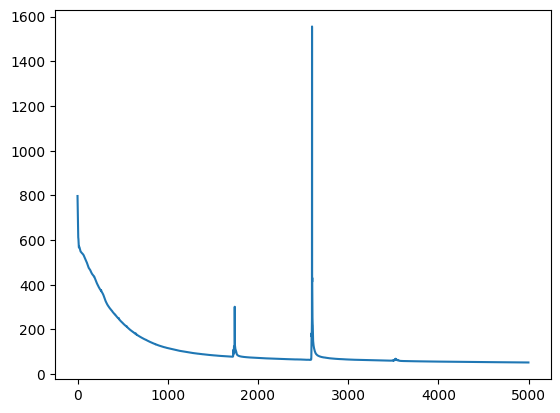

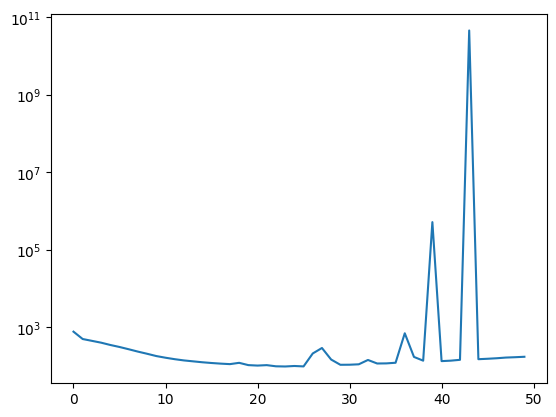

In [73]:
plt.plot(stats['posVfe'], label='posVfe')
plt.show()
plt.plot(stats['valVfe'], label='valVfe')
plt.yscale('log')
plt.show()

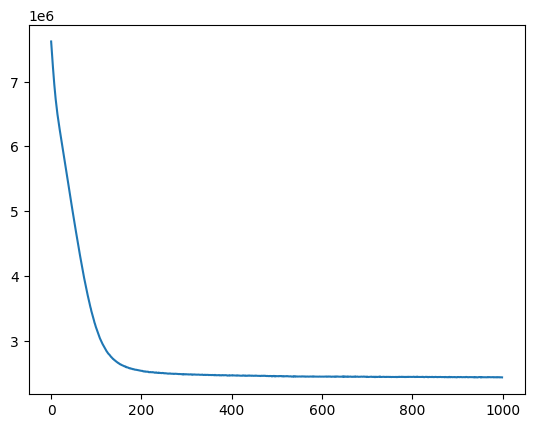

In [101]:
model.eval()
state = model.init_state(val_dataset.transformed_images.flatten(1).clone())
vfes = []
for _ in range(1000):
    model.step(state)
    vfes.append(model.vfe(state).item())

plt.plot(vfes)

sparsity: 0.0
tensor(0.1018, device='cuda:0', grad_fn=<MseLossBackward0>)


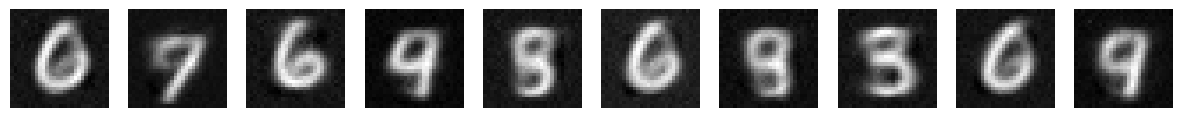

In [98]:
model.train()
imgs = train_dataset.images.clone().flatten(1)
imgs.shape

state = model(imgs, steps=1000)
pred, _, _ = model.predict(state['z'])
print(f'sparsity: {(state["z"] == 0).float().mean().item()}')
mse = F.mse_loss(pred, imgs)
print(mse)

# show first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(pred[i].view(28, 28).detach().cpu(), cmap='gray')
    ax.axis('off')

In [43]:
model.eval()
imgs = train_dataset.transformed_images.clone().flatten(1)
imgs.shape
out, state = model(imgs, pin_obs=True)

out, state = model(y=out, pin_target=True, steps=500)
reconstructions = state[0]['x']
mse = F.mse_loss(reconstructions, imgs)
print(mse)

# show first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(state[0]['x'][i].view(28, 28).detach().cpu(), cmap='gray')
    ax.axis('off')

TypeError: Model.forward() got an unexpected keyword argument 'pin_obs'

final mse:  0.06963910907506943


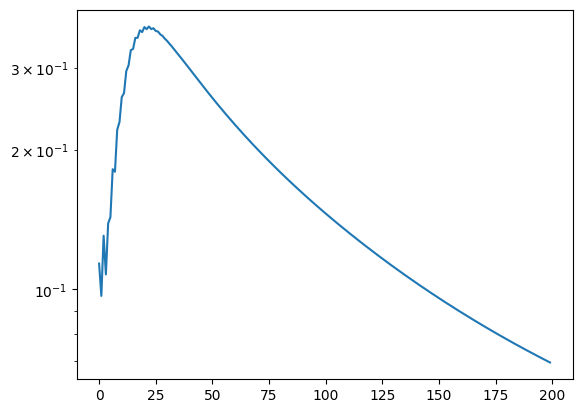

In [73]:
imgs = train_dataset.transformed_images.clone().flatten(1)
imgs.shape
out, state = model(imgs, pin_obs=True, steps=200)

mse = []
state = model.init_state(y=out)
gamma = torch.ones(state[0]['x'].shape[0], device=device) * 0.2
prev_vfe = None
with torch.no_grad():
    for _ in range(200):
        model.step(state, gamma, pin_target=True)
        reconstructions = state[0]['x']
        mse.append(F.mse_loss(reconstructions, imgs).item())
        gamma, prev_vfe = model.update_gamma(state, gamma, prev_vfe)

print('final mse: ', mse[-1])
plt.plot(mse)
plt.yscale('log')

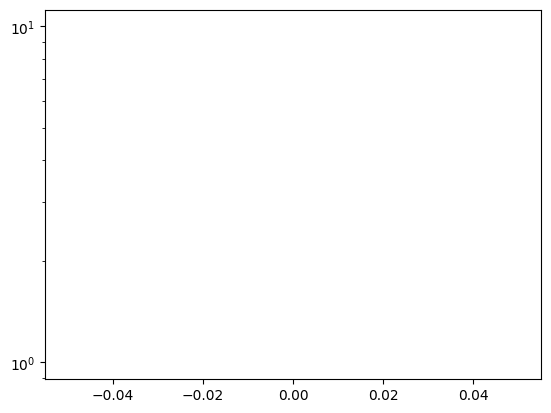

In [331]:
plt.plot(stats['negMse'])
plt.yscale('log')

In [20]:
all_stats['classic'] = stats

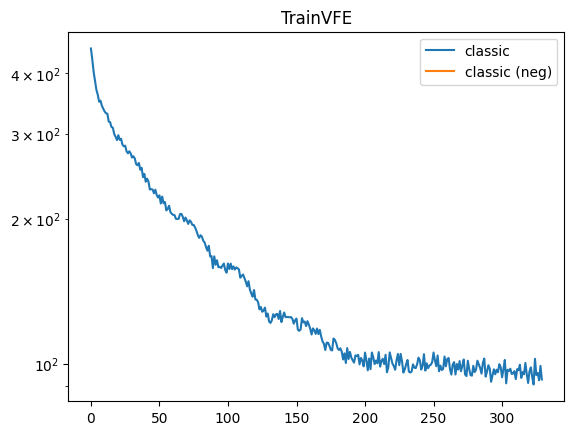

In [21]:
for k, v in all_stats.items():
    plt.plot(v['posVfe'], label=k)
    plt.plot(v['negVfe'], label=k+' (neg)')
plt.legend()
plt.yscale('log')
plt.title('TrainVFE')
plt.show()

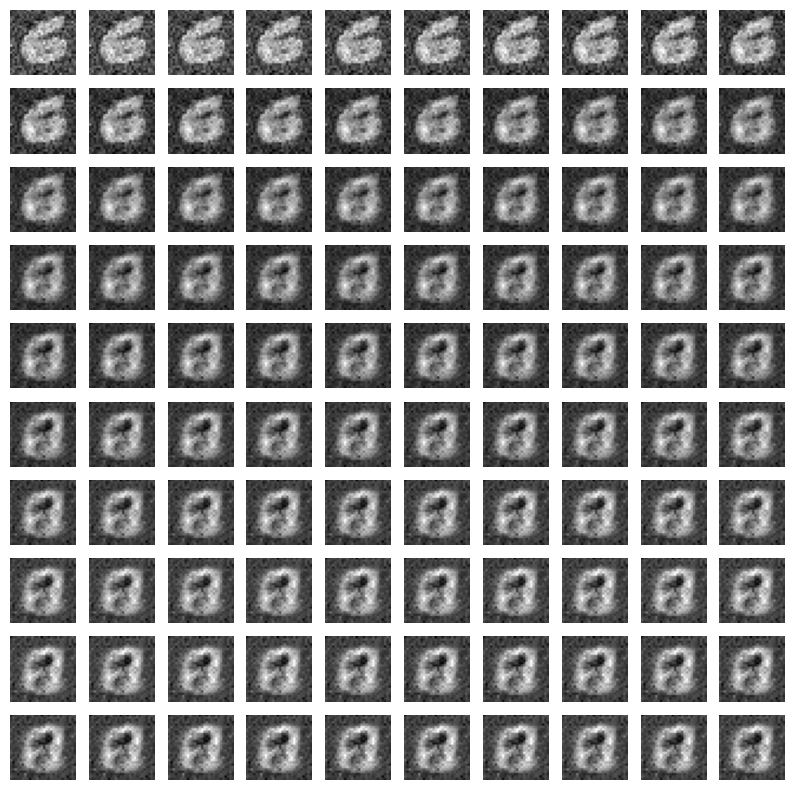

Final MSE:  0.0009774883510544896
Final VFE:  103.29932403564453
Min MSE:  0.00022827685461379588
Min VFE:  82.48310089111328


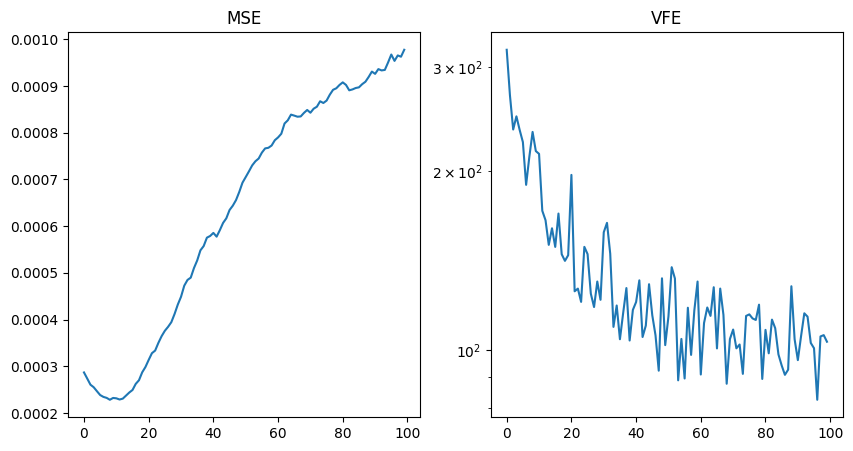

In [55]:
model.eval()
og = train_dataset.images[0].flatten(1).clone()
x = og.clone() + torch.randn_like(og) * 0.3
# x[torch.rand_like(x) > 0.7] = 0.0
# errs = [F.mse_loss(x, og).item()]
vfes = []
errs = []


# Plot the first 1st digit after multiple steps
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes):
    for j, ax2 in enumerate(ax):
        img = x.cpu().reshape(28,28).detach()
        # img = (F.normalize(x.cpu(), 1).reshape(28,28).detach() - F.normalize(og.cpu(), 1).reshape(28,28).detach()).abs()
        ax2.imshow(img, cmap='gray')
        x, state = model.reconstruct(x, steps=60, beta=0.05)
        errs.append(F.mse_loss(F.normalize(x), F.normalize(og)).item())
        # errs.append(F.mse_loss(x, og).item())
        vfes.append(model.vfe(state).item())
        ax2.axis('off')

plt.show()

print('Final MSE: ', errs[-1])
print('Final VFE: ', vfes[-1])
print('Min MSE: ', min(errs))
print('Min VFE: ', min(vfes))
# Plot MSE and VFE, VFE logarithmically
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(errs)
axes[0].set_title('MSE')
axes[1].plot(vfes)
axes[1].set_yscale('log')
axes[1].set_title('VFE')
plt.show()


In [335]:
torch.save(model.state_dict(), 'examples\mnist\out\models\mnist_original.pth')

In [102]:
def train_classifier(
        model,
        classifier,
        NUM_EPOCHS,
        train_dataset,
        val_dataset,
        stats,
        model_steps=100,
):
    # Init data
    trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False)
    valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False)

    data = []
    model.eval()
    print('Preparing training data...', flush=True)
    loop = tqdm(trainLoader, total=len(trainLoader), leave=False)
    for images, labels in loop:
        data.append((model.mu(model(images.flatten(1), steps=model_steps)['z']).detach(), labels))
    
    print('Preparing validation data...', flush=True)
    val_data = []
    loop = tqdm(valLoader, total=len(valLoader), leave=False)
    for images, labels in loop:
        val_data.append((model.mu(model(images.flatten(1), steps=model_steps)['z']).detach(), labels))
        # val_data.append((model(images.flatten(1), steps=60)['z'].detach(), labels))

    for i in range(NUM_EPOCHS):
        classifier.train()
        # Epoch stats
        epochLosses = []
        epochAccs = []

        optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.001, weight_decay=0.02)

        # TQDM loop
        loop = tqdm(trainLoader, total=len(trainLoader), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            loop.set_postfix({'trainLoss': stats['trainLoss'][-1], 'valLoss': stats['valLoss'][-1], 'valAcc': stats['valAcc'][-1]})

        # Iterate over all batches
        for z, labels in data:
            out = classifier(z.detach())

            optimiser.zero_grad()
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimiser.step()
            epochLosses.append(loss.item())
            epochAccs.append((out.argmax(1) == labels).float().mean().item())

        # Track epoch stats
        stats['trainLoss'].append(torch.tensor(epochLosses).mean().item())
        stats['trainAcc'].append(torch.tensor(epochAccs).mean().item())

        # Update learning rate
        # if scheduler is not None:
        #     scheduler.step(stats['ValAcc'][-1])

        # Validation pass
        val_losses = []
        val_accs = []
        for z, labels in val_data:
            out = classifier(z)
            val_losses.append(F.cross_entropy(out, labels))
            val_accs.append((out.argmax(1) == labels).float().mean())

        stats['valAcc'].append(torch.tensor(val_accs).mean().item() * 100.0)
        stats['valLoss'].append(torch.tensor(val_losses).mean().item())
        
        stats['epoch'] += 1

In [103]:
classifier = torch.nn.Sequential(
    # torch.nn.Linear(600, 200),
    # torch.nn.ReLU(),
    # torch.nn.Linear(200, 10, bias=False),
    torch.nn.Linear(64, 10, bias=False),
).to(device)
class_stats = {
    'epoch': 0,
    'trainLoss': [],
    'trainAcc': [],
    'valAcc': [],
    'valLoss': [],
}

In [104]:
NUM_EPOCHS = 100
train_classifier(
    model,
    classifier,
    NUM_EPOCHS,
    train_dataset,
    val_dataset,
    class_stats,
    model_steps=350,
    # eval_every=10,
)

Preparing training data...


Preparing validation data...


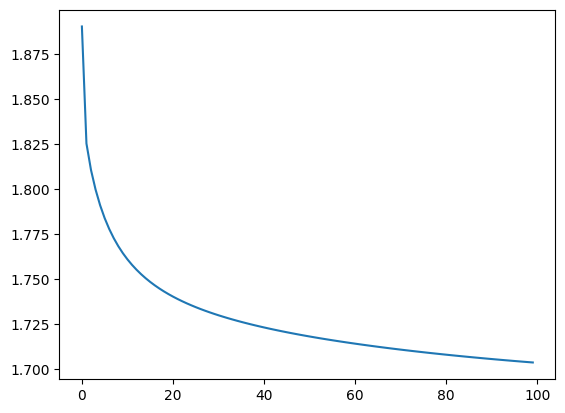

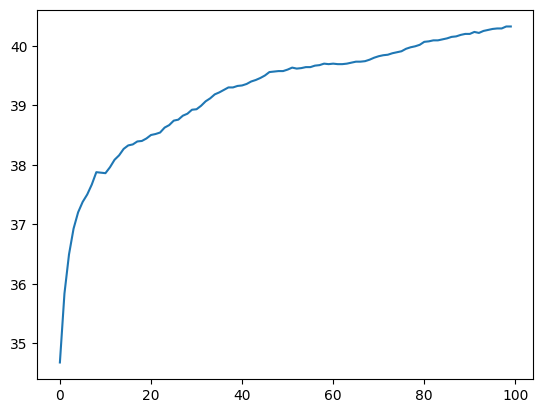

In [105]:
plt.plot(class_stats['trainLoss'])
plt.show()
plt.plot(class_stats['valAcc'])

In [31]:
class_stats['valAcc'][-1]

85.9250009059906